In [1]:
from scipy import stats
import os
import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize
import pickle

[nltk_data] Downloading package punkt to /h/usen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
SECTION_TITLES = re.compile(
    r'('
    r'ABDOMEN AND PELVIS|CLINICAL HISTORY|CLINICAL INDICATION|COMPARISON|COMPARISON STUDY DATE'
    r'|EXAM|EXAMINATION|FINDINGS|HISTORY|IMPRESSION|INIDICATION'
    r'|MEDICAL CONDITION|PROCEDURE|REASON FOR EXAM|REASON FOR STUDY|REASON FOR THIS EXAMINATION'
    r'|TECHNIQUE'
    r'):FINAL REPORT',
    re.I | re.M)

In [29]:
def pattern_repl(matchobj):
    return ' '.rjust(len(matchobj.group(0)))

In [30]:
def find_end(text):
    ends = [len(text)]
    patterns = [
        re.compile(r'BY ELECTRONICALLY SIGNING THIS REPORT', re.I),
        re.compile(r'\n {3,}DR.', re.I),
        re.compile(r'[ ]{1,}RADLINE ', re.I),
        re.compile(r'.*electronically signed on', re.I),
        re.compile(r'M\[0KM\[0KM')
    ]
    for pattern in patterns:
        matchobj = pattern.search(text)
        if matchobj:
            ends.append(matchobj.start())
    return min(ends)

In [31]:
def split_heading(text):
    start = 0
    for matcher in SECTION_TITLES.finditer(text):
        # add last
        end = matcher.start()
        if end != start:
            section = text[start:end].strip()
            if section:
                yield section

        # add title
        start = end
        end = matcher.end()
        if end != start:
            section = text[start:end].strip()
            if section:
                yield section

        start = end

    # add last piece
    end = len(text)
    if start < end:
        section = text[start:end].strip()
        if section:
            yield section

In [32]:
def clean_text(text):
    """
    Clean text
    """

    # Replace [**Patterns**] with spaces.
    text = re.sub(r'\[\*\*.*?\*\*\]', pattern_repl, text)
    # Replace `_` with spaces.
    text = re.sub(r'_', ' ', text)

    start = 0
    end = find_end(text)
    new_text = ''
    if start > 0:
        new_text += ' ' * start
    new_text = text[start:end]

    # make sure the new text has the same length of old text.
    if len(text) - end > 0:
        new_text += ' ' * (len(text) - end)
    return new_text

In [33]:
def preprocess_mimic(text):
    """
    Preprocess reports in MIMIC-III.
    1. remove [**Patterns**] and signature
    2. split the report into sections
    3. tokenize sentences and words
    4. lowercase
    """
    for sec in split_heading(clean_text(text)):
        for sent in sent_tokenize(sec):
            text = ' '.join(word_tokenize(sent))
            yield text.lower()

In [2]:
df = pd.read_csv('./data/notes/radiology.csv.gz', compression='gzip')
df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032-RR-18,10000032,NaN,RR,18,2180-06-03 12:46:00,2180-06-03 14:01:00,EXAMINATION: Ultrasound-guided paracentesis.\...
4,10000032-RR-20,10000032,NaN,RR,20,2180-07-08 13:18:00,2180-07-08 14:15:00,EXAMINATION: Paracentesis\n\nINDICATION: ___...
...,...,...,...,...,...,...,...,...
2321350,19999987-RR-17,19999987,23865745.0,RR,17,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
2321351,19999987-RR-18,19999987,23865745.0,RR,18,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
2321352,19999987-RR-19,19999987,23865745.0,RR,19,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
2321353,19999987-RR-20,19999987,23865745.0,RR,20,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [3]:
RAW_DATA_PATH = '/datasets/MIMIC-IV/physionet.org/files/mimiciv/2.2/'
adm = pd.read_csv(os.path.join(RAW_DATA_PATH,'hosp/admissions.csv.gz'),
                  usecols=['hadm_id', 'subject_id','admittime'])
adm

,subject_id,hadm_id,admittime
0,10000032,22595853,2180-05-06 22:23:00
1,10000032,22841357,2180-06-26 18:27:00
2,10000032,25742920,2180-08-05 23:44:00
3,10000032,29079034,2180-07-23 12:35:00
4,10000068,25022803,2160-03-03 23:16:00
...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00
431227,19999828,29734428,2147-07-18 16:23:00
431228,19999840,21033226,2164-09-10 13:47:00
431229,19999840,26071774,2164-07-25 00:27:00


In [4]:
adm_df = adm.merge(df, on=['subject_id', 'hadm_id'], how='inner')
adm_df

,subject_id,hadm_id,admittime,note_id,note_type,note_seq,charttime,storetime,text
0,10000032,22595853,2180-05-06 22:23:00,10000032-RR-14,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032,22595853,2180-05-06 22:23:00,10000032-RR-15,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032,22595853,2180-05-06 22:23:00,10000032-RR-16,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032,22841357,2180-06-26 18:27:00,10000032-RR-22,RR,22,2180-06-26 17:15:00,2180-06-26 19:28:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
4,10000032,22841357,2180-06-26 18:27:00,10000032-RR-23,RR,23,2180-06-26 17:17:00,2180-06-26 17:28:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
...,...,...,...,...,...,...,...,...,...
1144753,19999987,23865745,2145-11-02 21:38:00,19999987-RR-17,RR,17,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
1144754,19999987,23865745,2145-11-02 21:38:00,19999987-RR-18,RR,18,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
1144755,19999987,23865745,2145-11-02 21:38:00,19999987-RR-19,RR,19,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
1144756,19999987,23865745,2145-11-02 21:38:00,19999987-RR-20,RR,20,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [10]:
df.charttime = pd.to_datetime(df.charttime)
df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032-RR-18,10000032,NaN,RR,18,2180-06-03 12:46:00,2180-06-03 14:01:00,EXAMINATION: Ultrasound-guided paracentesis.\...
4,10000032-RR-20,10000032,NaN,RR,20,2180-07-08 13:18:00,2180-07-08 14:15:00,EXAMINATION: Paracentesis\n\nINDICATION: ___...
...,...,...,...,...,...,...,...,...
2321350,19999987-RR-17,19999987,23865745.0,RR,17,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
2321351,19999987-RR-18,19999987,23865745.0,RR,18,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
2321352,19999987-RR-19,19999987,23865745.0,RR,19,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
2321353,19999987-RR-20,19999987,23865745.0,RR,20,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [11]:
df = df[df.subject_id.notnull()]
df = df[df.hadm_id.notnull()]
df = df[df.charttime.notnull()]
df = df[df.text.notnull()]
df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
6,10000032-RR-22,10000032,22841357.0,RR,22,2180-06-26 17:15:00,2180-06-26 19:28:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
7,10000032-RR-23,10000032,22841357.0,RR,23,2180-06-26 17:17:00,2180-06-26 17:28:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
...,...,...,...,...,...,...,...,...
2321350,19999987-RR-17,19999987,23865745.0,RR,17,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
2321351,19999987-RR-18,19999987,23865745.0,RR,18,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
2321352,19999987-RR-19,19999987,23865745.0,RR,19,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
2321353,19999987-RR-20,19999987,23865745.0,RR,20,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [12]:
df = df[['subject_id', 'hadm_id', 'charttime', 'text']]
df

,subject_id,hadm_id,charttime,text
0,10000032,22595853.0,2180-05-06 21:19:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032,22595853.0,2180-05-06 23:00:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032,22595853.0,2180-05-07 09:55:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
6,10000032,22841357.0,2180-06-26 17:15:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
7,10000032,22841357.0,2180-06-26 17:17:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
...,...,...,...,...
2321350,19999987,23865745.0,2145-11-02 22:37:00,"HISTORY: ___, with left occipital bleeding. ..."
2321351,19999987,23865745.0,2145-11-03 04:35:00,INDICATION: ___ female intubated for head ble...
2321352,19999987,23865745.0,2145-11-03 16:40:00,HISTORY: ___ woman with left occipital hemorr...
2321353,19999987,23865745.0,2145-11-04 05:10:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [13]:
df.to_csv('./data/notes/filtered_radiology_notes.csv.gz', compression='gzip', index=False)

In [3]:
df = pd.read_csv('./data/notes/filtered_radiology_notes.csv.gz', compression='gzip').reset_index(drop=True)
# df

In [4]:
df.charttime = pd.to_datetime(df.charttime)
df

,subject_id,hadm_id,charttime,text
0,10000032,22595853.0,2180-05-06 21:19:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032,22595853.0,2180-05-06 23:00:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032,22595853.0,2180-05-07 09:55:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032,22841357.0,2180-06-26 17:15:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
4,10000032,22841357.0,2180-06-26 17:17:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
...,...,...,...,...
1144753,19999987,23865745.0,2145-11-02 22:37:00,"HISTORY: ___, with left occipital bleeding. ..."
1144754,19999987,23865745.0,2145-11-03 04:35:00,INDICATION: ___ female intubated for head ble...
1144755,19999987,23865745.0,2145-11-03 16:40:00,HISTORY: ___ woman with left occipital hemorr...
1144756,19999987,23865745.0,2145-11-04 05:10:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [5]:
notes = df.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)
notes['group_start_time'] = notes.groupby('subject_id')['charttime'].transform('first')
notes['minutes'] = (notes['charttime'] - notes['group_start_time']).dt.total_seconds() / 60

notes.drop(columns=['group_start_time', 'charttime'], inplace=True)
notes

,subject_id,hadm_id,text,minutes
0,10000032,22595853.0,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,0.0
1,10000032,22595853.0,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,101.0
2,10000032,22595853.0,"INDICATION: ___ HCV cirrhosis c/b ascites, hi...",756.0
3,10000032,22841357.0,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,73196.0
4,10000032,22841357.0,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,73198.0
...,...,...,...,...
1144753,19999987,23865745.0,"HISTORY: ___, with left occipital bleeding. ...",135.0
1144754,19999987,23865745.0,INDICATION: ___ female intubated for head ble...,493.0
1144755,19999987,23865745.0,HISTORY: ___ woman with left occipital hemorr...,1218.0
1144756,19999987,23865745.0,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...,1968.0


In [ ]:
def get_sentences(t):
    return list(preprocess_mimic(t))

In [38]:
notes.text = notes.text.apply(get_sentences)
notes

,subject_id,hadm_id,text,minutes
0,10000032,22595853.0,[examination : chest ( pa and lat ) indication...,0.0
1,10000032,22595853.0,[examination : liver or gallbladder us ( singl...,101.0
2,10000032,22595853.0,"[indication : hcv cirrhosis c/b ascites , hiv ...",756.0
3,10000032,22841357.0,[examination : liver or gallbladder us ( singl...,73196.0
4,10000032,22841357.0,[examination : chest ( pa and lat ) indication...,73198.0
...,...,...,...,...
1144753,19999987,23865745.0,"[history : , with left occipital bleeding ., a...",135.0
1144754,19999987,23865745.0,[indication : female intubated for head bleed ...,493.0
1144755,19999987,23865745.0,[history : woman with left occipital hemorrhag...,1218.0
1144756,19999987,23865745.0,"[portable chest of comparison : radiograph ., ...",1968.0


In [39]:
notes.to_csv('./data/notes/filtered_cleaned_radiology_notes.csv.gz', compression='gzip', index=False)

In [2]:
_, oc, _, _, _ = pickle.load(open('./data/processed/mimic_iv_disch.pkl', 'rb'))
oc

,ts_id,hadm_id,subject_id,admittime,minutes
0,37067082,24597018,10001217,2157-11-18 22:56:00,0.0
1,31205490,25563031,10001725,2110-04-11 15:08:00,0.0
2,37510196,26184834,10001884,2131-01-07 20:39:00,0.0
3,39060235,23581541,10002013,2160-05-18 07:45:00,0.0
4,33685454,23822395,10002155,2129-08-04 12:44:00,0.0
...,...,...,...,...,...
57530,37364566,21439025,19999297,2162-08-14 23:55:00,0.0
57531,32336619,26785317,19999442,2148-11-19 10:00:00,0.0
57532,36075953,25744818,19999828,2149-01-08 16:44:00,0.0
57533,38978960,21033226,19999840,2164-09-10 13:47:00,0.0


In [6]:
df_oc = oc.merge(df, on=['subject_id', 'hadm_id'], how='left')
df_oc

,ts_id,hadm_id,subject_id,admittime,minutes,charttime,text
0,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-18 21:55:00,STUDY: MRI OF THE HEAD WITH AND WITHOUT CONTR...
1,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-20 08:00:00,STUDY: MRI of the head with contrast.\n\nCLIN...
2,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-20 14:14:00,HISTORY: UNDERLYING MEDICAL CONDITION: ___ ye...
3,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-21 13:59:00,"CT OF THE HEAD WITHOUT CONTRAST, ___\n\nHISTOR..."
4,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-22 12:22:00,HISTORY: Female with new right PICC.\n\nTECHN...
...,...,...,...,...,...,...,...
578089,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-02 22:37:00,"HISTORY: ___, with left occipital bleeding. ..."
578090,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-03 04:35:00,INDICATION: ___ female intubated for head ble...
578091,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-03 16:40:00,HISTORY: ___ woman with left occipital hemorr...
578092,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-04 05:10:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [7]:
df_oc['time_difference'] = (pd.to_datetime(df_oc.charttime) - pd.to_datetime(df_oc.admittime)).dt.total_seconds() / 3600
df_oc


,ts_id,hadm_id,subject_id,admittime,minutes,charttime,text,time_difference
0,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-18 21:55:00,STUDY: MRI OF THE HEAD WITH AND WITHOUT CONTR...,-1.016667
1,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-20 08:00:00,STUDY: MRI of the head with contrast.\n\nCLIN...,33.066667
2,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-20 14:14:00,HISTORY: UNDERLYING MEDICAL CONDITION: ___ ye...,39.300000
3,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-21 13:59:00,"CT OF THE HEAD WITHOUT CONTRAST, ___\n\nHISTOR...",63.050000
4,37067082,24597018,10001217,2157-11-18 22:56:00,0.0,2157-11-22 12:22:00,HISTORY: Female with new right PICC.\n\nTECHN...,85.433333
...,...,...,...,...,...,...,...,...
578089,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-02 22:37:00,"HISTORY: ___, with left occipital bleeding. ...",0.983333
578090,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-03 04:35:00,INDICATION: ___ female intubated for head ble...,6.950000
578091,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-03 16:40:00,HISTORY: ___ woman with left occipital hemorr...,19.033333
578092,36195440,23865745,19999987,2145-11-02 21:38:00,0.0,2145-11-04 05:10:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...,31.533333


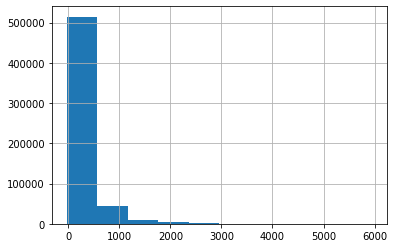

In [8]:
import matplotlib.pyplot as plt
df_oc['time_difference'].hist()
plt.show()

In [9]:
oc.shape

(57535, 4)

In [8]:
df_oc

,ts_id,hadm_id,subject_id,in_hospital_mortality,note_id,note_type,note_seq,charttime,storetime,text
0,37067082,24597018,10001217,0,10001217-RR-10,RR,10.0,2157-11-18 21:55:00,2157-11-19 15:09:00,STUDY: MRI OF THE HEAD WITH AND WITHOUT CONTR...
1,37067082,24597018,10001217,0,10001217-RR-11,RR,11.0,2157-11-20 08:00:00,2157-11-21 09:55:00,STUDY: MRI of the head with contrast.\n\nCLIN...
2,37067082,24597018,10001217,0,10001217-RR-13,RR,13.0,2157-11-20 14:14:00,2157-11-20 18:10:00,HISTORY: UNDERLYING MEDICAL CONDITION: ___ ye...
3,37067082,24597018,10001217,0,10001217-RR-14,RR,14.0,2157-11-21 13:59:00,2157-11-21 17:09:00,"CT OF THE HEAD WITHOUT CONTRAST, ___\n\nHISTOR..."
4,37067082,24597018,10001217,0,10001217-RR-15,RR,15.0,2157-11-22 12:22:00,2157-11-22 14:42:00,HISTORY: Female with new right PICC.\n\nTECHN...
...,...,...,...,...,...,...,...,...,...,...
578089,36195440,23865745,19999987,0,19999987-RR-17,RR,17.0,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
578090,36195440,23865745,19999987,0,19999987-RR-18,RR,18.0,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
578091,36195440,23865745,19999987,0,19999987-RR-19,RR,19.0,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
578092,36195440,23865745,19999987,0,19999987-RR-20,RR,20.0,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [25]:
notes = pd.read_csv('./data/notes/filtered_cleaned_radiology_notes.csv.gz', compression='gzip')

In [5]:
notes_merged = oc[['ts_id', 'hadm_id', 'subject_id']].merge(notes, on='hadm_id', how='left')
notes_merged

,ts_id,hadm_id,subject_id_x,subject_id_y,text,minutes
0,37067082,24597018,10001217,10001217.0,"['history : multiple sclerosis , presenting wi...",0.0
1,37067082,24597018,10001217,10001217.0,['study : mri of the head with and without con...,182.0
2,37067082,24597018,10001217,10001217.0,"['study : mri of the head with contrast .', 'c...",2227.0
3,37067082,24597018,10001217,10001217.0,['history : underlying medical condition : yea...,2601.0
4,37067082,24597018,10001217,10001217.0,"['ct of the head without contrast , history : ...",4026.0
...,...,...,...,...,...,...
578089,36195440,23865745,19999987,19999987.0,"['history : , with left occipital bleeding .',...",135.0
578090,36195440,23865745,19999987,19999987.0,['indication : female intubated for head bleed...,493.0
578091,36195440,23865745,19999987,19999987.0,['history : woman with left occipital hemorrha...,1218.0
578092,36195440,23865745,19999987,19999987.0,['portable chest of comparison : radiograph .'...,1968.0


In [6]:
os.makedirs('./data/processed', exist_ok=True)
pickle.dump([data, notes_merged, train_ids, val_ids, test_ids], 
            open('./data/processed/mimic_iv_notes.pkl','wb'))

In [21]:
oc_notes = pd.DataFrame(pickle.load(open('./data/processed/mimic_iv_notes.pkl', 'rb'))[0])
oc_notes

,ts_id,hadm_id,subject_id,text,minutes
0,37067082,24597018,10001217,"['history : multiple sclerosis , presenting wi...",0.0
1,37067082,24597018,10001217,['study : mri of the head with and without con...,182.0
2,37067082,24597018,10001217,"['study : mri of the head with contrast .', 'c...",2227.0
3,37067082,24597018,10001217,['history : underlying medical condition : yea...,2601.0
4,37067082,24597018,10001217,"['ct of the head without contrast , history : ...",4026.0
...,...,...,...,...,...
578089,36195440,23865745,19999987,"['history : , with left occipital bleeding .',...",135.0
578090,36195440,23865745,19999987,['indication : female intubated for head bleed...,493.0
578091,36195440,23865745,19999987,['history : woman with left occipital hemorrha...,1218.0
578092,36195440,23865745,19999987,['portable chest of comparison : radiograph .'...,1968.0


In [22]:
oc_notes.to_csv('./data/notes/final_radiology_notes.csv.gz', compression='gzip', index=False)

In [3]:
oc_notes= pd.read_csv('./data/notes/final_radiology_notes.csv.gz', compression='gzip')
oc_notes

,ts_id,hadm_id,subject_id,text,minutes
0,37067082,24597018,10001217,"['history : multiple sclerosis , presenting wi...",0.0
1,37067082,24597018,10001217,['study : mri of the head with and without con...,182.0
2,37067082,24597018,10001217,"['study : mri of the head with contrast .', 'c...",2227.0
3,37067082,24597018,10001217,['history : underlying medical condition : yea...,2601.0
4,37067082,24597018,10001217,"['ct of the head without contrast , history : ...",4026.0
...,...,...,...,...,...
578089,36195440,23865745,19999987,"['history : , with left occipital bleeding .',...",135.0
578090,36195440,23865745,19999987,['indication : female intubated for head bleed...,493.0
578091,36195440,23865745,19999987,['history : woman with left occipital hemorrha...,1218.0
578092,36195440,23865745,19999987,['portable chest of comparison : radiograph .'...,1968.0


In [8]:
import ast
print(" ".join(ast.literal_eval(oc_notes['text'].iloc[0])))

history : multiple sclerosis , presenting with flaring fever . technique : frontal and lateral views of the chest . comparison : none . findings : there is mild left base atelectasis seen on the frontal view without clear correlate on the lateral view . no definite focal consolidation is seen . there is no pleural effusion or pneumothorax . the aorta is slightly tortuous . the cardiac silhouette is not enlarged . there is no overt pulmonary edema . impression : mild left base atelectasis . otherwise , no acute cardiopulmonary process .


In [12]:
oc_notes = oc_notes.dropna()
oc_notes

,ts_id,hadm_id,subject_id,text,minutes
0,37067082,24597018,10001217,"['history : multiple sclerosis , presenting wi...",0.0
1,37067082,24597018,10001217,['study : mri of the head with and without con...,182.0
2,37067082,24597018,10001217,"['study : mri of the head with contrast .', 'c...",2227.0
3,37067082,24597018,10001217,['history : underlying medical condition : yea...,2601.0
4,37067082,24597018,10001217,"['ct of the head without contrast , history : ...",4026.0
...,...,...,...,...,...
578089,36195440,23865745,19999987,"['history : , with left occipital bleeding .',...",135.0
578090,36195440,23865745,19999987,['indication : female intubated for head bleed...,493.0
578091,36195440,23865745,19999987,['history : woman with left occipital hemorrha...,1218.0
578092,36195440,23865745,19999987,['portable chest of comparison : radiograph .'...,1968.0


In [13]:
oc_notes.to_csv('./data/notes/final_radiology_notes.csv.gz', compression='gzip', index=False)

In [ ]:
oc_notes= pd.read_csv('./data/notes/final_radiology_notes.csv.gz', compression='gzip')
# oc_notes.isna().sum()

: 

In [5]:
oc_notes[oc_notes.ts_id == 30619019]

,ts_id,hadm_id,subject_id,text,minutes
254892,30619019,21041514,14412499,"['history : hepatocellular carcinoma , recurre...",903686.0
254893,30619019,21041514,14412499,['chest radiograph indication : evaluation for...,905364.0
254894,30619019,21041514,14412499,['chest radiograph indication : status post li...,905635.0
254895,30619019,21041514,14412499,['history : woman status post liver transplant...,905701.0
254896,30619019,21041514,14412499,['indication : history of hepatocellular carci...,906043.0
254897,30619019,21041514,14412499,"['history : liver transplant , to assess for h...",907042.0
254898,30619019,21041514,14412499,['history : postop day 2 status post liver tra...,907403.0
254899,30619019,21041514,14412499,"['history : right ij exchanged .', 'findings :...",907576.0
254900,30619019,21041514,14412499,['history : history of nephrolithiasis now sta...,910203.0


In [4]:
oc_notes.dtypes

ts_id           int64
hadm_id         int64
subject_id      int64
text           object
minutes       float64
dtype: object

In [2]:
_, oc, _, _, _ = pickle.load(open('./data/processed/mimic_iv_disch.pkl', 'rb'))

In [4]:
oc[oc.ts_id == 30619019]['minutes'].iloc[-1]

0.0

In [33]:
no_notes = oc[~oc['hadm_id'].isin(oc_notes['hadm_id'])]


In [27]:
notes.hadm_id.unique().shape

(309670,)

In [32]:
oc[oc['hadm_id'].isin(notes['hadm_id'])].hadm_id.unique().shape

(51092,)

In [41]:
oc[oc.hadm_id.isin(no_notes.hadm_id)].minutes.value_counts()

0.0          1476
1756684.0       2
152876.0        1
78927.0         1
364863.0        1
             ... 
4860384.0       1
432174.0        1
61653.0         1
185760.0        1
94594.0         1
Name: minutes, Length: 295, dtype: int64

In [36]:
_, mortality, _, _, _ = pickle.load(open('./data/processed/mimic_iv.pkl', 'rb'))
mortality

,ts_id,hadm_id,subject_id,in_hospital_mortality
0,37067082,24597018,10001217,0
1,31205490,25563031,10001725,0
2,37510196,26184834,10001884,1
3,39060235,23581541,10002013,0
4,33685454,23822395,10002155,0
...,...,...,...,...
57530,37364566,21439025,19999297,1
57531,32336619,26785317,19999442,0
57532,36075953,25744818,19999828,0
57533,38978960,21033226,19999840,1


In [39]:
mortality[mortality.hadm_id.isin(no_notes.hadm_id)].in_hospital_mortality.value_counts()

0    1751
1      20
Name: in_hospital_mortality, dtype: int64